In [7]:
%pip install --upgrade --force-reinstall pillow

Defaulting to user installation because normal site-packages is not writeable
  Using cached pillow-12.1.0-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (8.8 kB)
Using cached pillow-12.1.0-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (7.0 MB)
  Attempting uninstall: pillow
    Found existing installation: pillow 12.1.0
    Uninstalling pillow-12.1.0:
      Successfully uninstalled pillow-12.1.0
Note: you may need to restart the kernel to use updated packages.


# 🔤 From Text to Attention

By the end of this notebook, you'll understand:
1. How text becomes tokens (and why it matters)
2. How tokens become meaningful vectors (embeddings)
3. How position information gets added
4. How attention actually works — coded from scratch

Let's start!

---
# Part 1: Tokenization
*What does the model actually see?*

---

In [8]:
# First, install tiktoken (OpenAI's tokenizer)
%pip install tiktoken -q
%pip install numpy


Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [9]:
import tiktoken
import numpy as np

# Load GPT-4's tokenizer
tokenizer = tiktoken.get_encoding("cl100k_base")

print(f"Vocabulary size: {tokenizer.n_vocab:,} tokens")

Vocabulary size: 100,277 tokens


## 1.1 Basic Tokenization

Let's see how text gets converted to numbers.

In [10]:
# Simple example
text = "Hello world"
tokens = tokenizer.encode(text)

print(f"Text: '{text}'")
print(f"Tokens: {tokens}")
print(f"Number of tokens: {len(tokens)}")

# Let's see what each token represents
print("\nToken breakdown:")
for token in tokens:
    print(f"  {token} → '{tokenizer.decode([token])}'")

Text: 'Hello world'
Tokens: [9906, 1917]
Number of tokens: 2

Token breakdown:
  9906 → 'Hello'
  1917 → ' world'


Notice: "Hello" is one token, but " world" (with the space!) is another.
The space attaches to the following word.


In [11]:
# Let's try more interesting examples
examples = [
    "Hello world",
    "don't",
    "artificial intelligence",
    "I love AI",
    "supercalifragilisticexpialidocious",
    "🚀",
    "café",
    "    spaces    ",  # multiple spaces
]

print("How different texts get tokenized:\n")
for text in examples:
    tokens = tokenizer.encode(text)
    print(f"'{text}'")
    print(f"  → {len(tokens)} tokens: {tokens}")

    # Show the pieces
    pieces = [tokenizer.decode([t]) for t in tokens]
    print(f"  → pieces: {pieces}")
    print()

How different texts get tokenized:

'Hello world'
  → 2 tokens: [9906, 1917]
  → pieces: ['Hello', ' world']

'don't'
  → 2 tokens: [15357, 956]
  → pieces: ['don', "'t"]

'artificial intelligence'
  → 3 tokens: [472, 16895, 11478]
  → pieces: ['art', 'ificial', ' intelligence']

'I love AI'
  → 3 tokens: [40, 3021, 15592]
  → pieces: ['I', ' love', ' AI']

'supercalifragilisticexpialidocious'
  → 11 tokens: [13066, 3035, 278, 333, 4193, 321, 4633, 4683, 532, 307, 78287]
  → pieces: ['sup', 'erc', 'al', 'if', 'rag', 'il', 'istic', 'exp', 'ial', 'id', 'ocious']

'🚀'
  → 3 tokens: [9468, 248, 222]
  → pieces: ['�', '�', '�']

'café'
  → 2 tokens: [936, 59958]
  → pieces: ['ca', 'fé']

'    spaces    '
  → 3 tokens: [262, 12908, 257]
  → pieces: ['   ', ' spaces', '    ']



## 🧪 Try It Yourself

Tokenize your own text! Try:
- Your name
- A sentence in another language
- Some code
- Emojis

In [12]:
# YOUR TURN: Change this text and see how it tokenizes
my_text = "my name is prem"

tokens = tokenizer.encode(my_text)
print(f"Text: '{my_text}'")
print(f"Tokens: {tokens}")
print(f"Number of tokens: {len(tokens)}")
print(f"Pieces: {[tokenizer.decode([t]) for t in tokens]}")

Text: 'my name is prem'
Tokens: [2465, 836, 374, 6954]
Number of tokens: 4
Pieces: ['my', ' name', ' is', ' prem']


## 1.2 Why Tokenization Matters

Token count affects:
- API costs (you pay per token)
- Context limits (GPT-4 has 128K token limit)
- Model behavior (some tasks break across token boundaries)

In [13]:
test_cases = {
    "English prose": "The quick brown fox jumps over the lazy dog.",
    "Python code": "def hello():\n    print('Hello, world!')",
    "JSON": '{"name": "Alice", "age": 30, "city": "NYC"}',
    "Numbers": "1234567890 9876543210 1111111111",
    "URL": "https://www.example.com/path/to/page?query=value",
}

print("Token efficiency comparison:\n")
for name, text in test_cases.items():
    tokens = tokenizer.encode(text)
    chars = len(text)
    ratio = chars / len(tokens)
    print(f"{name}:")
    print(f"  {chars} chars → {len(tokens)} tokens ({ratio:.1f} chars/token)")
    print()

Token efficiency comparison:

English prose:
  44 chars → 10 tokens (4.4 chars/token)

Python code:
  39 chars → 11 tokens (3.5 chars/token)

JSON:
  43 chars → 19 tokens (2.3 chars/token)

Numbers:
  32 chars → 14 tokens (2.3 chars/token)

URL:
  48 chars → 11 tokens (4.4 chars/token)



**Key insight**: Different content has different token efficiency.
- English prose: ~4 characters per token
- Code/JSON: often less efficient (more tokens per character)
- This affects your API costs!

## 1.3 The Token Boundary Problem

Some tasks are hard because they require reasoning WITHIN tokens.

In [14]:
# Why LLMs struggle with letter counting

word = "strawberry"
tokens = tokenizer.encode(word)

print(f"Word: '{word}'")
print(f"Tokens: {tokens}")
print(f"Pieces: {[tokenizer.decode([t]) for t in tokens]}")
print()
print("The model sees these pieces, not individual letters!")
print("Counting 'r's requires looking INSIDE tokens — that's hard.")

Word: 'strawberry'
Tokens: [496, 675, 15717]
Pieces: ['str', 'aw', 'berry']

The model sees these pieces, not individual letters!
Counting 'r's requires looking INSIDE tokens — that's hard.


In [15]:
# Another example: reversing words

word = "hello"
tokens = tokenizer.encode(word)
print(f"'{word}' → tokens: {[tokenizer.decode([t]) for t in tokens]}")
print()
print("If 'hello' is ONE token, the model can't easily reverse it.")
print("It would need to decompose something it sees as atomic.")

'hello' → tokens: ['hello']

If 'hello' is ONE token, the model can't easily reverse it.
It would need to decompose something it sees as atomic.


---
# ✅ Checkpoint: Tokenization Complete

You now understand:
- Text → Token IDs (integers)
- Subword tokenization (BPE)
- Why token counts matter
- Why some tasks are hard (token boundaries)

**→ Back to slides for Embeddings**

---

---
# Part 2: Embeddings
*Tokens as points in space*

---

In [16]:
%pip install matplotlib
%pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# We'll use a small pre-computed set of embeddings for demonstration
# In practice, you'd load these from a model

## 2.1 What's an Embedding?

An embedding converts a token ID into a vector of numbers.
Let's simulate this with random embeddings first, then use real ones.

In [18]:
# Simulating an embedding matrix
vocab_size = 50000
embedding_dim = 768  # GPT-2 size

# Random embedding matrix (in reality, this is LEARNED)
embedding_matrix = np.random.randn(vocab_size, embedding_dim) * 0.02

print(f"Embedding matrix shape: {embedding_matrix.shape}")
print(f"  → {vocab_size:,} tokens")
print(f"  → {embedding_dim} dimensions per token")
print(f"  → {vocab_size * embedding_dim:,} total parameters just for embeddings!")

Embedding matrix shape: (50000, 768)
  → 50,000 tokens
  → 768 dimensions per token
  → 38,400,000 total parameters just for embeddings!


In [19]:
# How embedding lookup works

text = "Hello world"
tokens = tokenizer.encode(text)

print(f"Text: '{text}'")
print(f"Token IDs: {tokens}")
print()

# Look up each token's embedding
for token_id in tokens:
    embedding = embedding_matrix[token_id]
    print(f"Token {token_id} ('{tokenizer.decode([token_id])}')")
    print(f"  → Embedding shape: {embedding.shape}")
    print(f"  → First 10 values: {embedding[:10].round(3)}")
    print()

Text: 'Hello world'
Token IDs: [9906, 1917]

Token 9906 ('Hello')
  → Embedding shape: (768,)
  → First 10 values: [-0.002 -0.009 -0.004 -0.007  0.018  0.007  0.021 -0.033 -0.014  0.013]

Token 1917 (' world')
  → Embedding shape: (768,)
  → First 10 values: [ 0.01   0.022  0.006  0.007 -0.019 -0.007 -0.005  0.009 -0.012  0.022]



## 2.2 Real Embeddings: Word Similarity

Let's use pre-trained word vectors to see embeddings in action.
We'll use Gensim's Word2Vec — classic but illustrative.

In [20]:
%pip install gensim -q

Note: you may need to restart the kernel to use updated packages.


In [21]:
import gensim.downloader as api

# Load pre-trained word vectors (this may take a minute)
print("Loading word vectors... (this takes ~1 minute)")
word_vectors = api.load("glove-wiki-gigaword-100")  # 100-dimensional GloVe
print(f"Loaded! Vocabulary: {len(word_vectors):,} words")

Loading word vectors... (this takes ~1 minute)
[==================================================] 100.0% 128.1/128.1MB downloaded
Loaded! Vocabulary: 400,000 words


In [22]:
# Find similar words

word = "king"
similar = word_vectors.most_similar(word, topn=10)

print(f"Words most similar to '{word}':\n")
for similar_word, score in similar:
    print(f"  {similar_word}: {score:.3f}")

Words most similar to 'king':

  prince: 0.768
  queen: 0.751
  son: 0.702
  brother: 0.699
  monarch: 0.698
  throne: 0.692
  kingdom: 0.681
  father: 0.680
  emperor: 0.671
  ii: 0.668


## 🧪 Try It Yourself

Find words similar to anything!

In [23]:
my_word = "yellow"

if my_word in word_vectors:
    similar = word_vectors.most_similar(my_word, topn=10)
    print(f"Words most similar to '{my_word}':\n")
    for w, score in similar:
        print(f"  {w}: {score:.3f}")
else:
    print(f"'{my_word}' not in vocabulary. Try another word.")

Words most similar to 'yellow':

  red: 0.860
  purple: 0.825
  pink: 0.787
  blue: 0.778
  green: 0.771
  orange: 0.736
  colored: 0.718
  black: 0.713
  dark: 0.703
  bright: 0.698


## 2.3 The Famous Analogy: King - Man + Woman = ?

In [24]:
# Vector arithmetic with words!

result = word_vectors.most_similar(
    positive=["king", "woman"],
    negative=["man"],
    topn=5
)

print("king - man + woman = ?\n")
for word, score in result:
    print(f"  {word}: {score:.3f}")

king - man + woman = ?

  queen: 0.770
  monarch: 0.684
  throne: 0.676
  daughter: 0.659
  princess: 0.652


In [25]:
# Try more analogies

analogies = [
    (["paris", "germany"], ["france"], "paris - france + germany = ?"),
    (["bigger", "cold"], ["big"], "bigger - big + cold = ?"),
]

for positive, negative, description in analogies:
    print(description)
    result = word_vectors.most_similar(positive=positive, negative=negative, topn=3)
    for word, score in result:
        print(f"  {word}: {score:.3f}")
    print()

paris - france + germany = ?
  berlin: 0.885
  frankfurt: 0.799
  vienna: 0.768

bigger - big + cold = ?
  cooler: 0.688
  warmer: 0.685
  colder: 0.675



## 2.4 Visualizing Embedding Space

Embeddings are high-dimensional. Let's project to 2D to visualize.

In [26]:
# Get embeddings for a set of related words
word_groups = {
    "royalty": ["king", "queen", "prince", "princess", "royal", "throne"],
    "family": ["man", "woman", "boy", "girl", "father", "mother"],
    "animals": ["dog", "cat", "horse", "bird", "fish", "lion"],
    "tech": ["computer", "software", "internet", "digital", "data", "code"],
}

# Collect all words and their embeddings
words = []
embeddings = []
colors = []
color_map = {"royalty": "purple", "family": "blue", "animals": "green", "tech": "red"}

for group, word_list in word_groups.items():
    for word in word_list:
        if word in word_vectors:
            words.append(word)
            embeddings.append(word_vectors[word])
            colors.append(color_map[group])

embeddings = np.array(embeddings)
print(f"Collected {len(words)} words, each with {embeddings.shape[1]} dimensions")

Collected 24 words, each with 100 dimensions


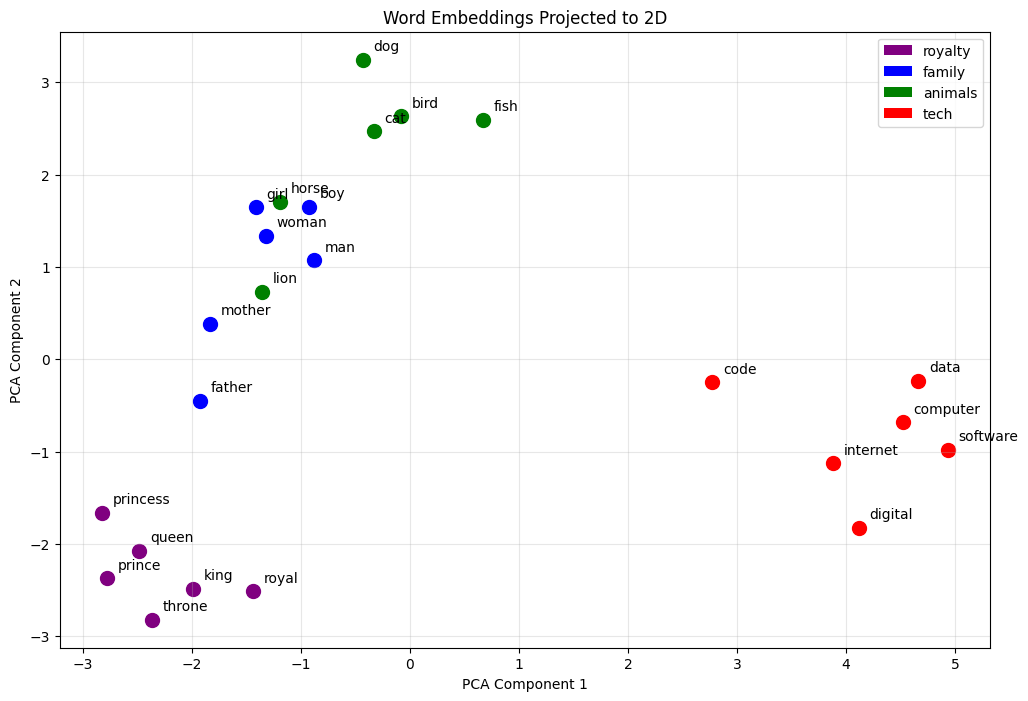

In [27]:
# Reduce to 2D using PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Plot
plt.figure(figsize=(12, 8))
for i, word in enumerate(words):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], c=colors[i], s=100)
    plt.annotate(word, (embeddings_2d[i, 0] + 0.1, embeddings_2d[i, 1] + 0.1))

plt.title("Word Embeddings Projected to 2D")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=g) for g, c in color_map.items()]
plt.legend(handles=legend_elements)
plt.grid(True, alpha=0.3)
plt.show()

Notice how words cluster by meaning!
- Royalty words are near each other
- Family words form another cluster
- This structure emerges from training, not manual design

---
# ✅ Checkpoint: Embeddings Complete

You now understand:
- Token ID → Embedding vector (lookup in a matrix)
- Similar meanings = nearby vectors
- Analogies work through vector arithmetic
- Embedding space has meaningful structure

**→ Back to slides for Positional Encoding**

---

---
# Part 3: Positional Encoding
*Injecting word order*

---

## 3.1 The Problem: Attention Loses Order

Let's see why we need positional encoding.

In [28]:
# Same words, different order, different meaning

sentence1 = "dog bites man"
sentence2 = "man bites dog"

tokens1 = tokenizer.encode(sentence1)
tokens2 = tokenizer.encode(sentence2)

print(f"'{sentence1}' → {tokens1}")
print(f"'{sentence2}' → {tokens2}")
print()
print("Same tokens, just reordered!")
print("Without position info, the model can't tell these apart.")

'dog bites man' → [18964, 49433, 893]
'man bites dog' → [1543, 49433, 5679]

Same tokens, just reordered!
Without position info, the model can't tell these apart.


## 3.2 The Sinusoidal Position Encoding

The original Transformer uses sine and cosine waves to encode position.

In [29]:
def get_positional_encoding(seq_length, d_model):
    """
    Generate sinusoidal positional encodings.

    Args:
        seq_length: Maximum sequence length
        d_model: Embedding dimension

    Returns:
        Positional encoding matrix of shape (seq_length, d_model)
    """
    position = np.arange(seq_length)[:, np.newaxis]  # (seq_length, 1)
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))

    pe = np.zeros((seq_length, d_model))
    pe[:, 0::2] = np.sin(position * div_term)  # Even indices: sine
    pe[:, 1::2] = np.cos(position * div_term)  # Odd indices: cosine

    return pe

# Generate positional encodings
seq_length = 100
d_model = 64  # Using smaller dimension for visualization

pe = get_positional_encoding(seq_length, d_model)
print(f"Positional encoding shape: {pe.shape}")
print(f"  → {seq_length} positions")
print(f"  → {d_model} dimensions")

Positional encoding shape: (100, 64)
  → 100 positions
  → 64 dimensions


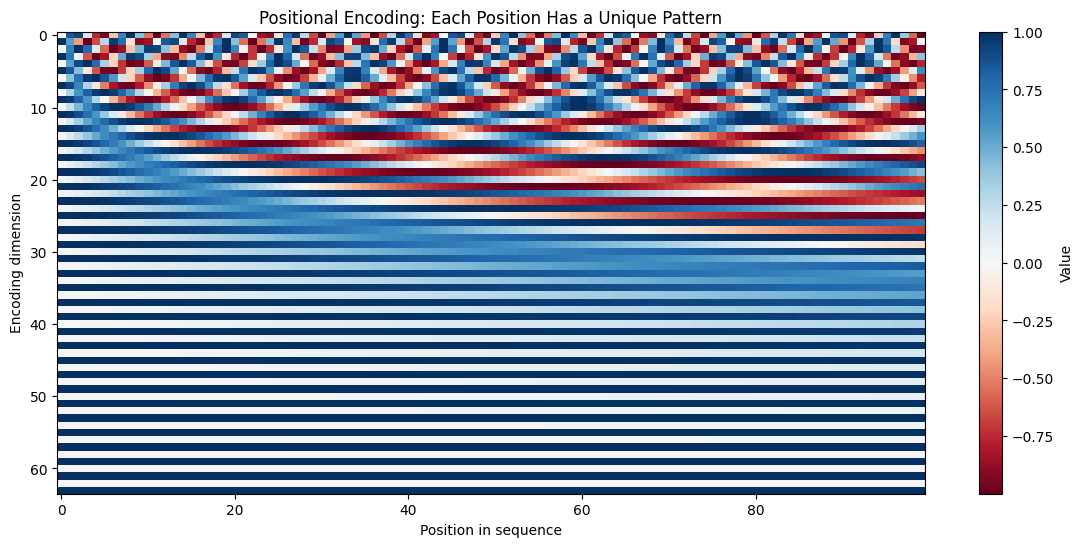

In [30]:
# Visualize the positional encodings

plt.figure(figsize=(14, 6))
plt.imshow(pe.T, aspect='auto', cmap='RdBu')
plt.colorbar(label='Value')
plt.xlabel('Position in sequence')
plt.ylabel('Encoding dimension')
plt.title('Positional Encoding: Each Position Has a Unique Pattern')
plt.show()

Each column is a position's encoding. Each row is a dimension.

Notice:
- Low dimensions (bottom) = low frequency waves (change slowly)
- High dimensions (top) = high frequency waves (change quickly)
- Each position has a UNIQUE pattern

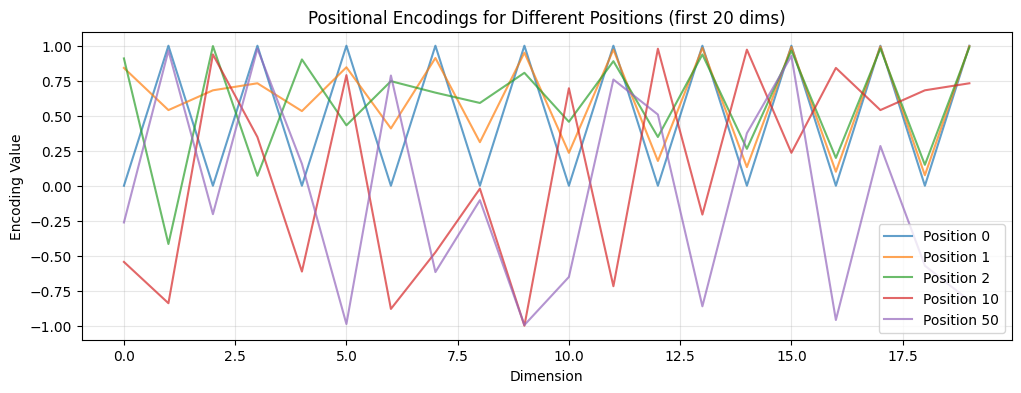

In [31]:
# Look at individual positions

positions_to_show = [0, 1, 2, 10, 50]

plt.figure(figsize=(12, 4))
for pos in positions_to_show:
    plt.plot(pe[pos, :20], label=f'Position {pos}', alpha=0.7)

plt.xlabel('Dimension')
plt.ylabel('Encoding Value')
plt.title('Positional Encodings for Different Positions (first 20 dims)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 3.3 How Position Gets Added

We simply ADD the positional encoding to the embedding.

In [32]:
# Simulate the full process

# Let's use a simple sentence
text = "The cat sat"
tokens = tokenizer.encode(text)
print(f"Text: '{text}'")
print(f"Tokens: {tokens}")

# Step 1: Get embeddings (using our random matrix from before)
d_model = 768
embedding_matrix = np.random.randn(50000, d_model) * 0.02
embeddings = np.array([embedding_matrix[t] for t in tokens])
print(f"\nEmbeddings shape: {embeddings.shape}")  # (3, 768)

# Step 2: Get positional encodings
pe = get_positional_encoding(len(tokens), d_model)
print(f"Positional encodings shape: {pe.shape}")  # (3, 768)

# Step 3: ADD them together
final_embeddings = embeddings + pe
print(f"Final embeddings shape: {final_embeddings.shape}")  # (3, 768)

print("\nNow each token's representation includes BOTH meaning AND position!")

Text: 'The cat sat'
Tokens: [791, 8415, 7731]

Embeddings shape: (3, 768)
Positional encodings shape: (3, 768)
Final embeddings shape: (3, 768)

Now each token's representation includes BOTH meaning AND position!


In [33]:
# Verify: same word at different positions has different representation

# "the" at position 0
the_pos0 = embedding_matrix[tokenizer.encode("the")[0]] + get_positional_encoding(1, d_model)[0]

# "the" at position 5 (simulated)
the_pos5 = embedding_matrix[tokenizer.encode("the")[0]] + get_positional_encoding(6, d_model)[5]

# How different are they?
difference = np.linalg.norm(the_pos0 - the_pos5)
print(f"Same word 'the' at position 0 vs position 5:")
print(f"  Euclidean distance: {difference:.4f}")
print(f"\nThe same word has DIFFERENT representations at different positions!")

Same word 'the' at position 0 vs position 5:
  Euclidean distance: 14.1023

The same word has DIFFERENT representations at different positions!


---
# ✅ Checkpoint: Positional Encoding Complete

You now understand:
- Why position matters (word order changes meaning)
- Sine/cosine waves create unique position patterns
- Position encoding ADDS to embeddings
- Same word at different positions → different representation

**→ Back to slides for Self-Attention**

---